In [32]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr

In [33]:
n_time = 156
n_geos = 17

time_index = np.arange(n_time)
random_geo_effect = np.random.normal(0, 30, n_geos)
intercept = 10_000

geo_intercept = intercept + random_geo_effect

season =  200 * np.sin(2 * np.pi * time_index / 52) + 50 * np.cos(4 * np.pi * time_index / 52)
start = "2022-01-03"
periods = pd.date_range(start=start, periods=n_time, freq='W-MON')

n_channels = 4
media_spend = np.random.exponential(100, size=(n_time, n_channels))*4

adstock_by_channel = np.array([.1, .3, .2, .4])

def apply_adstock(media_spend, adstock_by_channel):
    n_time, n_channels = media_spend.shape
    adstocked = np.zeros_like(media_spend)
    for i in range(n_channels):
        for t in range(n_time):
            if t == 0:
                adstocked[t, i] = media_spend[t, i]
            else:
                adstocked[t, i] = media_spend[t, i] + adstock_by_channel[i] * adstocked[t-1, i]
    return adstocked

adstocked_media = apply_adstock(media_spend, adstock_by_channel)
def apply_response(adstocked_media, response_by_channel):
    n_time, n_channels = adstocked_media.shape
    response = np.zeros_like(adstocked_media)
    for i in range(n_channels):
        response[:, i] = 1-np.exp(-response_by_channel[i] * adstocked_media[:, i]/np.max(adstocked_media[:, i]))
    return response

saturation_by_channel = [2, 3, 10, 5]
media_response = apply_response(adstocked_media, saturation_by_channel)

response_factor_by_channel = np.array([100, 200, 300, 400])
geo_offset_by_channel = np.random.normal(0, 10, (n_geos, n_channels))

response_factor_total_by_channelxgeo = response_factor_by_channel[np.newaxis, :] + geo_offset_by_channel
full_media_response = media_response[np.newaxis, :, :] * response_factor_total_by_channelxgeo[:, np.newaxis, :]
full_media_response.shape

trend = np.linspace(0, 300, n_time)

sales = geo_intercept[:, None] + trend[None, :] + full_media_response.sum(axis=-1) + season[None, :] + np.random.normal(0, 80, (n_geos, n_time))
full_media_response.sum(axis=0).sum(axis=0)/media_spend.sum(axis=0)


array([ 1.28461684,  3.5588733 ,  7.25644999, 11.71885744])

In [34]:
sales_xr = xr.DataArray(
    sales,
    dims=["Geography", "Period"],
    coords={"Geography": [f'geo_{i}' for i in range(n_geos)], "Period": periods}
)
media_spend_xr = xr.DataArray(
    media_spend,
    dims=["Period", "Channel"],
    coords={"Period": periods, "Channel": [f'channel_{i}' for i in range(n_channels)]}
)


In [46]:
sales_mff = sales_xr.to_dataframe("Sales").reset_index().melt(id_vars=["Geography", "Period"], value_name="VariableValue", var_name="VariableName")
media_mff = media_spend_xr.to_dataframe("MediaSpend").reset_index().rename(columns={"MediaSpend": "VariableValue", "Channel": "VariableName"})

In [48]:
mff = pd.concat([sales_mff, media_mff])
mff[["Product", "Campaign", "Outlet", "Creative"]] = np.nan
mff.head()

,Geography,Period,VariableName,VariableValue,Product,Campaign,Outlet,Creative
0,geo_0,2022-01-03,Sales,10443.928744,NaN,NaN,NaN,NaN
1,geo_0,2022-01-10,Sales,10244.525707,NaN,NaN,NaN,NaN
2,geo_0,2022-01-17,Sales,10673.173785,NaN,NaN,NaN,NaN
3,geo_0,2022-01-24,Sales,10816.464580,NaN,NaN,NaN,NaN
4,geo_0,2022-01-31,Sales,10610.670002,NaN,NaN,NaN,NaN


In [49]:
mff.to_csv("mff.csv", index=False)

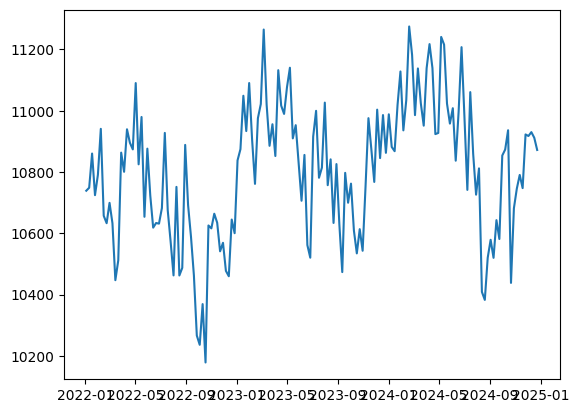

In [31]:
plt.plot(periods, sales[1])

In [20]:
import matplotlib.pyplot as plt

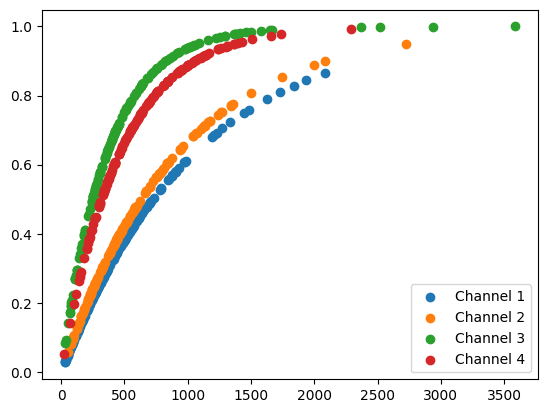

In [50]:
for i in range(4):
    plt.scatter(adstocked_media[:, i], media_response[:, i], label=f"Channel {i+1}")
plt.legend()
plt.show()